In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import os

# =========================================================
# 0) Seed 고정 함수 (매번 다른 시드 적용 예정)
# =========================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================================================
# 1) 평가 지표 함수
# =========================================================
def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom != 0
    smape = np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100
    return mae, rmse, smape

# =========================================================
# 데이터 전처리
# =========================================================
def clean_sales(df):
    if df['일매출'].dtype == 'object':
        df['일매출'] = df['일매출'].astype(str).str.replace(",", "").str.replace(" ", "").str.strip()
    df['일매출'] = pd.to_numeric(df['일매출'], errors='coerce').fillna(0)
    return df

def add_date_features(df):
    df['month'] = df['영업일자'].dt.month
    df['day'] = df['영업일자'].dt.day
    df['weekday'] = df['영업일자'].dt.weekday
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)

    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
    df['day_cos'] = np.cos(2 * np.pi * df['day']/31)

    df['open_hours'] = 11
    df.loc[df['weekday'] == 5, 'open_hours'] = 6
    df.loc[df['weekday'] == 6, 'open_hours'] = 0
    return df

def add_lag_features(df):
    df = df.copy()
    df['lag1'] = df['일매출'].shift(1)
    df['lag7'] = df['일매출'].shift(7)
    df['lag14'] = df['일매출'].shift(14)
    df['lag28'] = df['일매출'].shift(28)

    df['roll_mean7'] = df['일매출'].rolling(7).mean()
    df['roll_mean14'] = df['일매출'].rolling(14).mean()
    df['roll_mean28'] = df['일매출'].rolling(28).mean()

    df['roll_std7'] = df['일매출'].rolling(7).std()
    df['roll_std28'] = df['일매출'].rolling(28).std()
    return df

# =========================================================
# Sliding Window
# =========================================================
def create_sequences(df, feature_cols, target_col, seq_len=28):
    X, y = [], []
    feature_vals = df[feature_cols].values
    target_vals = df[target_col].values

    for i in range(seq_len, len(df)):
        seq_x = feature_vals[i-seq_len+1 : i+1]
        if len(seq_x) == seq_len:
            X.append(seq_x)
            y.append(target_vals[i])
    return np.array(X), np.array(y)

# =========================================================
# Dataset & Model
# =========================================================
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(self.relu(out[:, -1, :]))

# =========================================================
# 유연한 날짜 예측 함수 (순수 예측값 반환)
# =========================================================
def flexible_forecast_raw(model, df_history, df_future_meta, start_date, end_date, seq_len, feature_cols, scaler_X, scaler_y):
    model.eval()
    target_dates = pd.date_range(start=start_date, end=end_date)

    history = df_history.copy()
    preds = []

    for date in target_dates:
        if date not in df_future_meta['영업일자'].values:
            row = pd.Series(0, index=df_future_meta.columns)
            row['영업일자'] = date
        else:
            row = df_future_meta[df_future_meta['영업일자'] == date].iloc[0].copy()

        last_vals = history['일매출'].values

        row['lag1'] = last_vals[-1]
        row['lag7'] = last_vals[-7] if len(last_vals) >= 7 else 0
        row['lag14'] = last_vals[-14] if len(last_vals) >= 14 else 0
        row['lag28'] = last_vals[-28] if len(last_vals) >= 28 else 0

        row['roll_mean7']  = pd.Series(last_vals[-7:]).mean() if len(last_vals) >= 7 else 0
        row['roll_mean14'] = pd.Series(last_vals[-14:]).mean() if len(last_vals) >= 14 else 0
        row['roll_mean28'] = pd.Series(last_vals[-28:]).mean() if len(last_vals) >= 28 else 0

        row['roll_std7']  = pd.Series(last_vals[-7:]).std() if len(last_vals) >= 7 else 0
        row['roll_std28'] = pd.Series(last_vals[-28:]).std() if len(last_vals) >= 28 else 0

        row_df = pd.DataFrame([row])
        row_df = add_date_features(row_df)
        row = row_df.iloc[0].copy()

        temp_history = pd.concat([history.tail(seq_len-1), row_df], ignore_index=True)
        seq_unscaled = temp_history[feature_cols]
        seq_scaled = scaler_X.transform(seq_unscaled)

        X = torch.tensor(seq_scaled, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred_scaled = model(X).item()

        pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
        pred = max(pred, 0)

        # 여기서는 후처리(Holiday Fix)를 하지 않고 순수 예측값만 반환
        # 후처리는 앙상블 평균 낸 후에 마지막에 한 번만 적용

        preds.append(pred)

        row['일매출'] = pred
        history = pd.concat([history, pd.DataFrame([row])], ignore_index=True)

    return preds

# =========================================================
# 메인 실행
# =========================================================
TRAIN_PATH = '/content/drive/MyDrive/기계학습/팀플/Data/POS_train_val.csv'
TEST_PATH = '/content/drive/MyDrive/기계학습/팀플/Data/POS_test.csv'
ACAD_PATH = '/content/drive/MyDrive/기계학습/팀플/Data/학사일정_정리(2325).csv'

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
academic = pd.read_csv(ACAD_PATH)

train['영업일자'] = pd.to_datetime(train['영업일자'])
test['영업일자'] = pd.to_datetime(test['영업일자'])
academic['영업일자'] = pd.to_datetime(academic['date'])
academic = academic.drop(columns=['date'])

train = clean_sales(train)
test = clean_sales(test)

weekday_map = {'mon':0,'tue':1,'wed':2,'thu':3,'fri':4,'sat':5,'sun':6}
if 'weekday' in academic.columns:
    academic['acad_weekday'] = academic['weekday'].map(weekday_map)
    academic = academic.drop(columns=['weekday'])

academic = academic.rename(columns={
    'weekend':'acad_weekend', 'holiday':'acad_holiday', 'semester':'acad_semester',
    'seasonal':'acad_seasonal', 'exam':'acad_exam', 'ceremony':'acad_ceremony',
    'dormitory':'acad_dormitory'
})

train = train.merge(academic, on='영업일자', how='left')
test_meta = test.merge(academic, on='영업일자', how='left')

train = add_date_features(train)
test_meta = add_date_features(test_meta)

train = add_lag_features(train).dropna().reset_index(drop=True)

feature_cols = [
    'acad_weekend', 'acad_semester', 'acad_weekday',
    'open_hours', 'acad_ceremony', 'acad_exam',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'lag1','lag7','lag14','lag28',
    'roll_std7','roll_std28',
    'roll_mean7','roll_mean14','roll_mean28'
]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_scaled = train.copy()
train_scaled[feature_cols] = scaler_X.fit_transform(train[feature_cols])
train_scaled[['일매출']] = scaler_y.fit_transform(train[['일매출']])

seq_len = 28
X_train, y_train = create_sequences(train_scaled, feature_cols, '일매출', seq_len)
dataset = SequenceDataset(X_train, y_train)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# =========================================================
# 🔥 Seed Ensemble (5개 모델 학습)
# =========================================================
SEEDS = [42, 100, 2024, 777, 999]
all_preds = []

print(f"🚀 Seed Ensemble 시작 (총 {len(SEEDS)}개 모델 학습)...")

for i, seed in enumerate(SEEDS):
    print(f"\n[{i+1}/{len(SEEDS)}] Seed {seed} 학습 중...")
    set_seed(seed) # 시드 변경

    # 모델 초기화 (Best Config: 128 Hidden, MSE Loss)
    model = GRUModel(input_dim=len(feature_cols), hidden_dim=128, num_layers=2, dropout=0.3).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 학습
    model.train()
    for epoch in range(100): # Epoch 100
        for Xb, yb in loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            output = model(Xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()

    # 예측 (Raw 값)
    PREDICT_START_DATE = '2025-08-10'
    PREDICT_END_DATE = '2025-10-31'

    preds = flexible_forecast_raw(
        model, train, test_meta, PREDICT_START_DATE, PREDICT_END_DATE, seq_len, feature_cols, scaler_X, scaler_y
    )
    all_preds.append(preds)

# =========================================================
# 🎯 앙상블 평균 및 후처리
# =========================================================
print("\n🎯 앙상블 결과 집계 중...")

# 1. 평균 계산
avg_preds = np.mean(all_preds, axis=0)

# 2. 최종 후처리 (Holiday Fix + Threshold)
final_preds = []
target_dates = pd.date_range(start=PREDICT_START_DATE, end=PREDICT_END_DATE)

for i, date in enumerate(target_dates):
    pred = avg_preds[i]

    # 메타 정보 조회
    if date in test_meta['영업일자'].values:
        row = test_meta[test_meta['영업일자'] == date].iloc[0]

        is_sunday = (row['영업일자'].weekday() == 6)
        is_closed = (row.get('open_hours', 11) == 0)
        is_holiday = (row.get('acad_holiday', 0) == 1)

        # 🔥 [필살기] 휴일 강제 0원
        if is_sunday or is_closed or is_holiday:
            pred = 0

    # 🔥 [필살기] 노이즈 제거
    if pred < 10000:
        pred = 0

    final_preds.append(pred)

# 결과 DataFrame 생성
forecast_df = pd.DataFrame({'영업일자': target_dates, '예측매출': final_preds})

# =========================================================
# 📊 성능 평가
# =========================================================
actual_df = test[['영업일자', '일매출']].copy()
actual_df.rename(columns={'일매출': '일매출_실제'}, inplace=True)

pred_df = forecast_df[['영업일자', '예측매출']].copy()

comparison_df = pd.merge(actual_df, pred_df, on='영업일자', how='inner')

if not comparison_df.empty:
    mae, rmse, smape_val = calculate_metrics(comparison_df['일매출_실제'], comparison_df['예측매출'])

    print("\n" + "="*40)
    print(f"📊 성능 평가 결과 (비교 데이터: {len(comparison_df)}개)")
    print("="*40)
    print(f"1. MAE   : {mae:,.2f}")
    print(f"2. RMSE  : {rmse:,.2f}")
    print(f"3. SMAPE : {smape_val:.2f} %")
    print("="*40)

    comparison_df.to_csv("forecast_comparison_result_ensemble.csv", index=False)
    print("\n✅ 비교 결과 저장 완료: forecast_comparison_result_ensemble.csv")
else:
    print("\n⚠️ 예측 구간과 실제 Test 데이터 구간이 겹치지 않습니다.")

🚀 Seed Ensemble 시작 (총 5개 모델 학습)...

[1/5] Seed 42 학습 중...

[2/5] Seed 100 학습 중...

[3/5] Seed 2024 학습 중...

[4/5] Seed 777 학습 중...

[5/5] Seed 999 학습 중...

🎯 앙상블 결과 집계 중...

📊 성능 평가 결과 (비교 데이터: 83개)
1. MAE   : 51,518.54
2. RMSE  : 82,083.14
3. SMAPE : 59.59 %

✅ 비교 결과 저장 완료: forecast_comparison_result_ensemble.csv


### **데이터 정보**

데이터 로드 중...

📋 데이터 정밀 진단 리포트

1. 데이터 기간:
   - Train: 2023-08-01 ~ 2025-08-09 (740일)
   - Test : 2025-08-10 ~ 2025-10-31 (83일)

2. 매출 0원(휴무/결측) 비율:
   - Train: 198일 (26.8%)
   - Test : 30일 (36.1%)

3. 매출 통계 (0원 제외):
   - 평균: 300,682
   - 중앙값: 306,800
   - 최대값: 1,007,100
   - 표준편차: 159,473
   * 평균과 중앙값 차이: -6,118 (크면 치우침)

4. 요일별 평균 매출 (Train):
   - Mon: 280,150
   - Tue: 302,853
   - Wed: 297,254
   - Thu: 290,744
   - Fri: 246,811
   - Sat: 120,911
   - Sun: 1,385

5. 주기성 확인 (Autocorrelation):
   - 어제 매출과의 상관관계 (Lag1) : 0.5030
   - 7일 전 매출과의 상관관계 (Lag7) : 0.6840 (높아야 함)
   - 28일 전 매출과의 상관관계 (Lag28): 0.4411

6. Test 데이터 특이사항:
   - Test 기간 요일 분포:
weekday
Sunday       12
Monday       12
Tuesday      12
Wednesday    12
Thursday     12
Friday       12
Saturday     11
Name: count, dtype: int64

진단 완료! 위 내용을 복사해서 알려주세요.


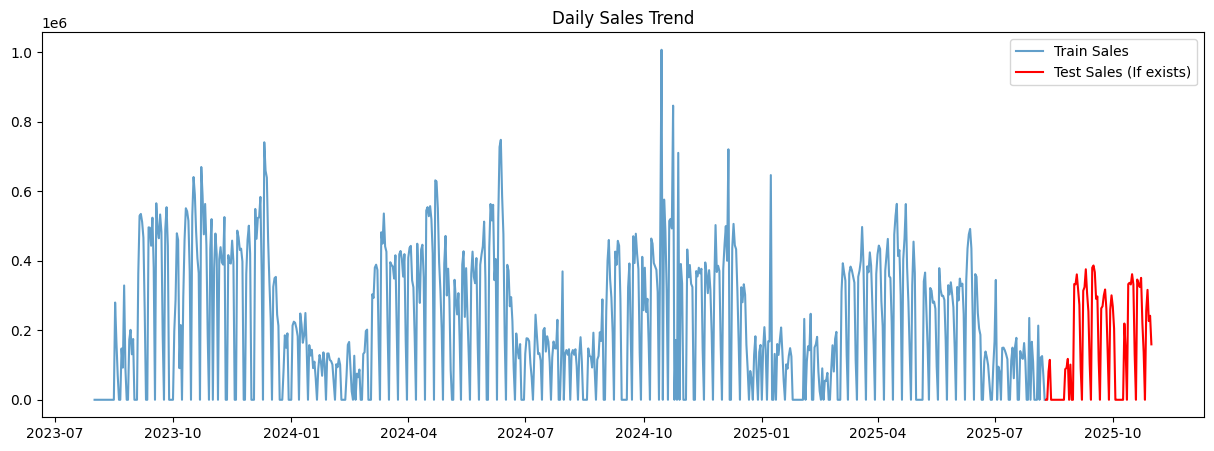

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


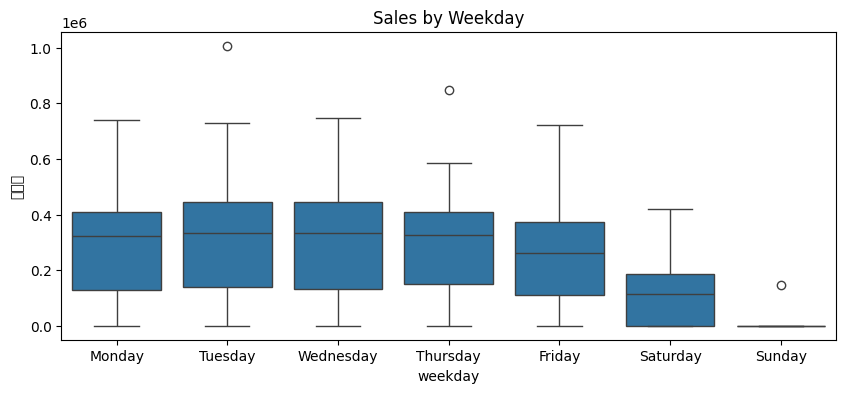

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 1. 데이터 로드 (경로 확인해주세요!)
# =========================================================
TRAIN_PATH = '/content/drive/MyDrive/기계학습/팀플/Data/POS_train_val.csv'
TEST_PATH = '/content/drive/MyDrive/기계학습/팀플/Data/POS_test.csv'

print("데이터 로드 중...")
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# 날짜 변환 및 전처리
train['영업일자'] = pd.to_datetime(train['영업일자'])
test['영업일자'] = pd.to_datetime(test['영업일자'])

def clean_sales(df):
    if df['일매출'].dtype == 'object':
        df['일매출'] = df['일매출'].astype(str).str.replace(",", "").str.replace(" ", "").str.strip()
    df['일매출'] = pd.to_numeric(df['일매출'], errors='coerce').fillna(0)
    return df

train = clean_sales(train)
test = clean_sales(test)

# =========================================================
# 2. 정밀 진단 리포트 출력
# =========================================================
print("\n" + "="*50)
print("📋 데이터 정밀 진단 리포트")
print("="*50)

# 1) 기본 통계
print(f"\n1. 데이터 기간:")
print(f"   - Train: {train['영업일자'].min().date()} ~ {train['영업일자'].max().date()} ({len(train)}일)")
print(f"   - Test : {test['영업일자'].min().date()} ~ {test['영업일자'].max().date()} ({len(test)}일)")

# 2) 0원(휴무일) 분석
zero_train = (train['일매출'] == 0).sum()
zero_test = (test['일매출'] == 0).sum()
print(f"\n2. 매출 0원(휴무/결측) 비율:")
print(f"   - Train: {zero_train}일 ({zero_train/len(train)*100:.1f}%)")
print(f"   - Test : {zero_test}일 ({zero_test/len(test)*100:.1f}%)")

# 3) 매출 분포 (왜도 확인)
sales_nonzero = train[train['일매출'] > 0]['일매출']
print(f"\n3. 매출 통계 (0원 제외):")
print(f"   - 평균: {sales_nonzero.mean():,.0f}")
print(f"   - 중앙값: {sales_nonzero.median():,.0f}")
print(f"   - 최대값: {sales_nonzero.max():,.0f}")
print(f"   - 표준편차: {sales_nonzero.std():,.0f}")
print(f"   * 평균과 중앙값 차이: {sales_nonzero.mean() - sales_nonzero.median():,.0f} (크면 치우침)")

# 4) 요일별 패턴 (매우 중요!)
train['weekday'] = train['영업일자'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_avg = train.groupby('weekday')['일매출'].mean().reindex(weekday_order)

print(f"\n4. 요일별 평균 매출 (Train):")
for day, avg in weekday_avg.items():
    print(f"   - {day[:3]}: {avg:,.0f}")

# 5) 자기상관성 (Autocorrelation) - 주기성 확인
print(f"\n5. 주기성 확인 (Autocorrelation):")
print(f"   - 어제 매출과의 상관관계 (Lag1) : {train['일매출'].autocorr(lag=1):.4f}")
print(f"   - 7일 전 매출과의 상관관계 (Lag7) : {train['일매출'].autocorr(lag=7):.4f} (높아야 함)")
print(f"   - 28일 전 매출과의 상관관계 (Lag28): {train['일매출'].autocorr(lag=28):.4f}")

# 6) Test 데이터 특이사항
print(f"\n6. Test 데이터 특이사항:")
# Test 기간에 포함된 요일 분포
test['weekday'] = test['영업일자'].dt.day_name()
print(f"   - Test 기간 요일 분포:\n{test['weekday'].value_counts()}")

print("\n" + "="*50)
print("진단 완료! 위 내용을 복사해서 알려주세요.")
print("="*50)

# (옵션) 시각화 - 코랩에서 바로 확인 가능
plt.figure(figsize=(15, 5))
plt.plot(train['영업일자'], train['일매출'], label='Train Sales', alpha=0.7)
plt.plot(test['영업일자'], test['일매출'], label='Test Sales (If exists)', color='red')
plt.title("Daily Sales Trend")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(x='weekday', y='일매출', data=train, order=weekday_order)
plt.title("Sales by Weekday")
plt.show()